In [361]:
import numpy as np
import tqdm
from numpy.random import default_rng
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt

In [362]:
class MulNormal:
    def __init__(self,
                 mean = [0, 0],
                 cov = [[1, 0], [0, 1]],
                 seed = 42
                 ):
        self.mean = mean
        self.cov = cov
        self.rng = default_rng(seed)
    
    def sample(self, size):
        return self.rng.multivariate_normal(self.mean, self.cov, size)
    
    def calc_loglikelihood(self, residuals):
        return -0.5 * (np.log(np.linalg.det(self.cov)) + residuals.T.dot(np.linalg.inv(self.cov)).dot(residuals) + 2 * np.log(2 * np.pi))
    
    def log_prob(self, x):
        residuals = (x - self.mean)

        return -0.5 * (np.sum(residuals.T * np.dot(np.linalg.inv(self.cov),residuals.T),axis=0) - np.log(np.linalg.det(self.cov)) + 2 * np.log(2 * np.pi))

In [363]:
class Categorical_np:
    def __init__(self,
                 logits):
        self.probs = np.exp(logits)
        denom = np.sum(self.probs, axis=-1, keepdims=True)
        self.probs /= denom
    
    def sample(self):
        return np.argmax(np.apply_along_axis(lambda x: np.random.multinomial(1, pvals=x), axis=-1, arr=self.probs), -1)

In [364]:
seed = 42
np.random.seed(42)
device = 'cpu'

#initialize dimension
dim = 10
#init scaling parameter for the density
a = 4.0
#standard deviations for the cluster centers
sigma = 1.0

#initialize centers of the clusters
center_pts = (np.random.rand(3,dim)-0.5)

locs = a*np.array([center_pts[0,0:(dim-2)].tolist() + [0.0, 1.0], \
                          center_pts[1,0:(dim-2)].tolist() + [np.sqrt(3)/2,-0.5], \
                          center_pts[2,0:(dim-2)].tolist()+ [-np.sqrt(3)/2,-0.5]])
covs = sigma*np.tile(np.eye(dim)[np.newaxis, ...], (3, 1, 1))
#normalized weights of the mixture
weights = np.array([1., 1., 1.])
weights /= weights.sum()
#create Gaussian densities with different centers
gaussians = [MulNormal(loc, cov) for loc, cov in zip(locs, covs)]

In [365]:
def log_prob(x):
        """
        Returns:
            log p(x)
        """
        log_ps = np.stack([
            np.log(weight) + gauss.log_prob(x) for weight, gauss in zip(weights, gaussians)
            ], axis=0)
#         return np.log(np.sum(np.exp(log_ps), 0))
        return logsumexp(log_ps, 0)

In [366]:
# I-SIR

def i_sir_step(log_target_dens, x_cur, N_part, isir_proposal, return_all_stats=False):
    """
    function to sample with N-particles version of i-SIR
    args:
        N_part - number of particles, integer;
        x0 - current i-sir particle;
    return:
        x_next - selected i-sir particle
    """
    N_samples, lat_size = x_cur.shape
    
    # generate proposals
    proposals = isir_proposal.sample((N_samples, N_part - 1, ))

    # put current particles
    proposals = np.concatenate((x_cur[:, np.newaxis, :], proposals), axis=1)

    # compute importance weights
    log_target_dens_proposals = log_target_dens(proposals.reshape(-1, lat_size)).reshape(N_samples, N_part)
    
    logw = log_target_dens_proposals - isir_proposal.log_prob(proposals.reshape(-1, lat_size)).reshape(N_samples, N_part)
    
    #sample selected particle indexes
    idxs = Categorical_np(logits=logw).sample()

    cur_x = proposals[np.arange(N_samples), idxs]
    
    if return_all_stats:
        return cur_x, proposals, log_target_dens_proposals
    else:
        return cur_x

def i_sir(log_target_dens, x0, N_steps, N_part, isir_proposal, seed=42):
    np.random.seed(seed)
    ### sample i-sir

    samples_traj = [x0]
    x_cur = x0
    
    for _ in tqdm.tqdm(range(N_steps)):
        x_cur = i_sir_step(log_target_dens, x_cur, N_part, isir_proposal)
        samples_traj.append(x_cur)

    samples_traj = np.stack(samples_traj).transpose(1, 0, 2)
    
    return samples_traj

In [367]:
N_traj = 5
#init starting points 
x0 = np.random.randn(N_traj, dim)

N_steps = 1000
N_part = 200
sigma_isir = 4.0

#choose proposal for i-SIR algorithm
isir_proposal = MulNormal(
    np.zeros(dim), (sigma_isir ** 2) * np.eye(dim)
)

#run i-SIR
Samples_isir = i_sir(log_prob, x0, N_steps, N_part, isir_proposal, seed=42)

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1279.67it/s]


In [368]:
Samples_isir.shape

(5, 1001, 10)

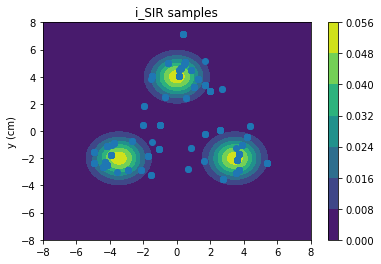

In [369]:
x = np.linspace(-2*a, 2*a, 100)
y = np.linspace(-2*a, 2*a, 100)
X, Y = np.meshgrid(x, y)
#stack the two
inp = np.stack([X, Y], -1)
proj_slice = [-2, -1]

#project onto the last 2 coordinates
loc_gaussians = [MulNormal(loc[proj_slice], cov[proj_slice, :][:, proj_slice]) for loc, cov in zip(locs, covs)]
log_ps = np.stack([
    np.log(weight) + gauss.log_prob(inp.reshape(-1, 2)) for weight, gauss in zip(weights, loc_gaussians)
], axis=0)
dens_vals = np.log(np.sum(np.exp(log_ps), 0)).reshape(inp.shape[:-1])
#plot density values
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, np.exp(dens_vals))
fig.colorbar(cp) # Add a colorbar to a plot
#plot i-sir samples
ax.scatter(Samples_isir[0,:,-2],Samples_isir[0,:,-1])
ax.set_title('i_SIR samples')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()